### 不同数据集排序

In [ ]:
from pathlib import Path

# 假设你的文件路径存储在一个列表中
breath_path_1 = [
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom10/50/9.270.5.1.dcm'),
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom10/50/9.270.5.2.dcm'),
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom10/50/9.270.5.3.dcm'),
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom10/50/9.270.5.100.dcm'),
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom10/50/9.270.5.101.dcm'),
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom10/50/9.270.5.102.dcm'),
    # ... 其他文件路径
]

breath_path_2 = [
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom1/50/50-slice000.dcm'),
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom1/50/50-slice001.dcm'),
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom1/50/50-slice002.dcm'),
    Path('/workspace/data/579/POPI_seq3_579/4DCT-Dicom1/50/50-slice003.dcm'),
    # ... 其他文件路径
]

def sort_paths(paths):
    # 判断文件名格式
    if paths and "slice" in paths[0].name:
        # 适用于 50-slice000.dcm 这种格式
        return sorted(paths)
    else:
        # 适用于 9.270.5.101.dcm 这种格式
        return sorted(paths, key=lambda x: int(x.stem.split('.')[-1]))

# 对两个列表分别进行排序
sorted_breath_path_1 = sort_paths(breath_path_1)
sorted_breath_path_2 = sort_paths(breath_path_2)

# 打印排序后的结果以验证
print("Sorted breath_path_1:")
for path in sorted_breath_path_1:
    print(path)

print("\nSorted breath_path_2:")
for path in sorted_breath_path_2:
    print(path)

## 查看像素值

In [17]:
import SimpleITK as sitk
import numpy as np

folder_path = '/workspace/data/579/POPI_seq3_579/4DCT-Dicom4/70'

# 使用SimpleITK的ImageSeriesReader读取DICOM序列
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
reader.SetFileNames(dicom_names)
image = reader.Execute()
image_array = sitk.GetArrayFromImage(image)

min_val = image_array.min()
max_val = image_array.max()
print("最小画素值:", min_val)
print("最大画素值:", max_val)

最小画素值: -1024
最大画素值: 2976


In [222]:
from skimage import io
# Load the new image
image_path = "/workspace/data/Overlap/SSIM&MAE/SMYellow_Mask_Patient5_GT5.png"
new_image = io.imread(image_path)

# Find the minimum and maximum pixel values
min_pixel_value = new_image.min()
max_pixel_value = new_image.max()

print("最小画素值:", min_pixel_value)
print("最大画素值:", max_pixel_value)

最小画素值: 0
最大画素值: 239


## PSNR

* PSNR

In [10]:
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from torchmetrics.image import PeakSignalNoiseRatio

# 加载图像
# image1_path = '/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Dark.png'  # 注意，这可能是错误的，因为两个文件名相同
# image2_path = '/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Light.png'  # 同上，实际路径可能需要根据文件的真实路径进行调整
image1_path = '/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png'
image2_path = '/workspace/data/Overlap/SSIM&MAE/SMRed_Mask_Patient5_GT5.png'  

# 将图像文件转换为Tensor
image1 = ToTensor()(Image.open(image1_path).convert('RGB'))
image2 = ToTensor()(Image.open(image2_path).convert('RGB'))

# 确保图像在同一设备上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image1 = image1.to(device)
image2 = image2.to(device)

# 初始化PSNR计算
psnr_metric = PeakSignalNoiseRatio(data_range=255.0).to(device)

# 计算PSNR
psnr_value = psnr_metric(image1.unsqueeze(0), image2.unsqueeze(0))
print("PSNR:", psnr_value.item())

PSNR: 58.94441223144531


In [11]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor

# 自定义PSNR计算函数
def custom_psnr(pred, target, max_pixel=255.0):
    mse = F.mse_loss(pred, target)
    if mse == 0:
        return torch.tensor(float('inf'))
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))

# 加载图像
# image1_path = '/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Dark.png'  # 注意，这可能是错误的，因为两个文件名相同
# image2_path = '/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Light.png'  # 同上，实际路径可能需要根据文件的真实路径进行调整
image1_path = '/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png'
image2_path = '/workspace/data/Overlap/SSIM&MAE/Shape_Dif/Patient6_GT.png' 

# 将图像文件转换为Tensor
image1 = ToTensor()(Image.open(image1_path).convert('RGB'))
image2 = ToTensor()(Image.open(image2_path).convert('RGB'))

# 确保图像在同一设备上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image1 = image1.to(device)
image2 = image2.to(device)

# 计算PSNR
psnr_value = custom_psnr(image1.unsqueeze(0), image2.unsqueeze(0))
psnr_value.item()

59.686161041259766

### PSNR Plot

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    # 'Fold': [1, 2, 3, 4, 5, 6],
    '4D-CT': [36.5957, 34.9455, 33.9995, 33.7551, 39.6594, 37.6953],
    '4D-CT+1D': [35.6282, 33.1064, 34.3769, 34.6647, 39.2639, 37.7497],
    # 'SSIM: 4D-CT+1D rpm': [0.8857, 0.7793, 0.8868, 0.8741, 0.9145, 0.9043],
    '4D-CT+2D': [41.4611, 39.574, 38.6543, 39.5339, 45.6676, 44.3769] # epoch 200 
}
df = pd.DataFrame(data)
# df.set_index('Fold', inplace=True)

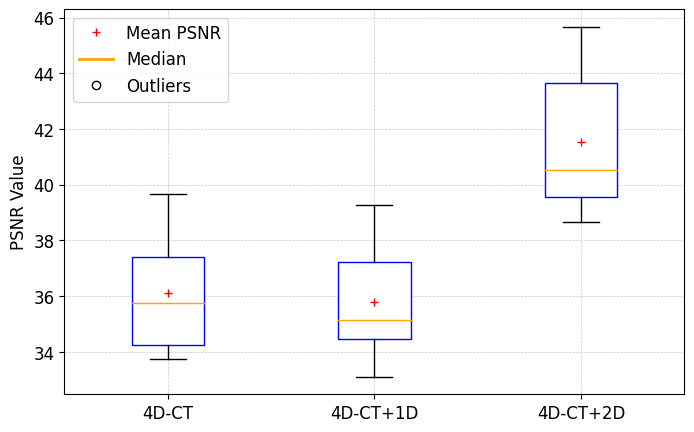

In [2]:
# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(8, 5))

# 全局设置字体大小
plt.rcParams.update({'font.size': 12})

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')
flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6) # Outlier

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['4D-CT'], df['4D-CT+1D'], df['4D-CT+2D']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops,
                              
                               # whis=(0, 100),  # 设置whis参数为(0, 100)以包含所有数据，解除将异常值视为正常数据
                               flierprops=flierprops # 异常值设定
                               # showfliers=False # 解除可以不显示异常值
                               )

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
# plt.title('Boxplot of SSIM Values')
plt.ylabel('PSNR Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean PSNR')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.plot([], [], 'o', markerfacecolor='white', markeredgecolor='black', label='Outliers', markersize=6)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0,1)

# Show the plot with mean points indicated
plt.show()

### Half 2D Plot

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    # 'Fold': [1, 2, 3, 4, 5, 6],
    '4D-CT+2D': [0.9497, 0.9026, 0.956, 0.9589, 0.9771, 0.9745], # epoch 200 
    '4D-CT+2D(Left Half)': [0.9413, 0.904, 0.9594, 0.9601, 0.9746, 0.9723],
    '4D-CT+2D(Right Half)': [0.9484, 0.9025, 0.9594, 0.9584, 0.9766, 0.9755]
    # 'SSIM: 4D-CT+1D rpm': [0.8857, 0.7793, 0.8868, 0.8741, 0.9145, 0.9043],
}
df = pd.DataFrame(data)
# df.set_index('Fold', inplace=True)

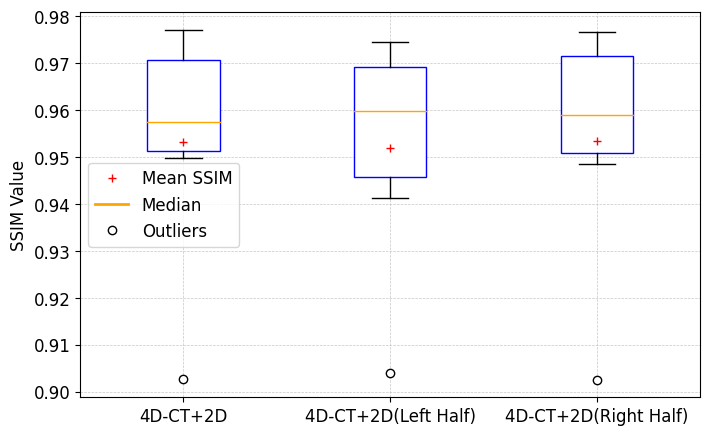

In [4]:
# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(8, 5))

# 全局设置字体大小
plt.rcParams.update({'font.size': 12})

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')
flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6) # Outlier

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['4D-CT+2D'], df['4D-CT+2D(Left Half)'], df['4D-CT+2D(Right Half)']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops,
                              
                               # whis=(0, 100),  # 设置whis参数为(0, 100)以包含所有数据，解除将异常值视为正常数据
                               flierprops=flierprops # 异常值设定
                               # showfliers=False # 解除可以不显示异常值
                               )

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
# plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean SSIM')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.plot([], [], 'o', markerfacecolor='white', markeredgecolor='black', label='Outliers', markersize=6)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0,1)

# Show the plot with mean points indicated
plt.show()

### Quarter 2D Plot

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    # 'Fold': [1, 2, 3, 4, 5, 6],
    '4D-CT+2D': [0.9497, 0.9026, 0.956, 0.9589, 0.9771, 0.9745], # epoch 200 
    'Top Left': [0.9498, 0.8993, 0.9604, 0.9564, 0.9745, 0.9739],
    'Top Right': [0.9515, 0.9041, 0.9602, 0.9585, 0.9777, 0.9755],
    'Bottom Left': [0.9503, 0.8961, 0.9596, 0.955, 0.9757, 0.9709],
    'Bottom Right': [0.9516, 0.9037, 0.9594, 0.958, 0.9758, 0.9698]
    # 'SSIM: 4D-CT+1D rpm': [0.8857, 0.7793, 0.8868, 0.8741, 0.9145, 0.9043],
}
df = pd.DataFrame(data)
# df.set_index('Fold', inplace=True)

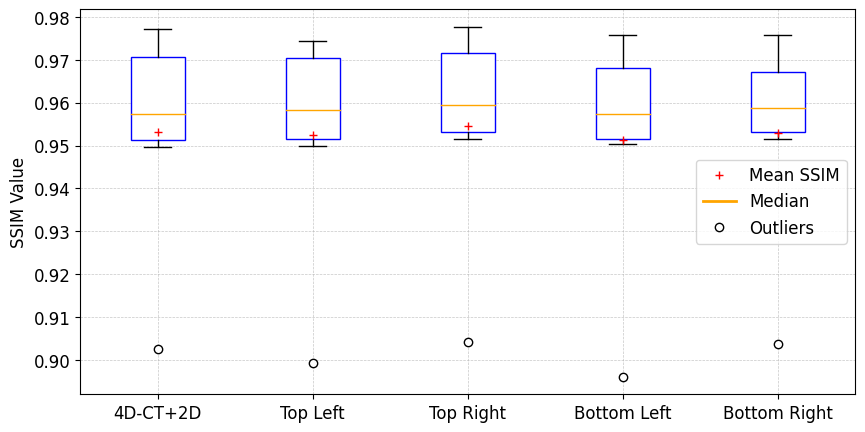

In [5]:
# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(10, 5))

# 全局设置字体大小
plt.rcParams.update({'font.size': 12})

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')
flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6) # Outlier

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['4D-CT+2D'], df['Top Left'], df['Top Right'], df['Bottom Left'], df['Bottom Right']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops,
                              
                               # whis=(0, 100),  # 设置whis参数为(0, 100)以包含所有数据，解除将异常值视为正常数据
                               flierprops=flierprops # 异常值设定
                               # showfliers=False # 解除可以不显示异常值
                               )

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
# plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean SSIM')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.plot([], [], 'o', markerfacecolor='white', markeredgecolor='black', label='Outliers', markersize=6)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0,1)

# Show the plot with mean points indicated
plt.show()

## SSIM and MAE

* SSIM

In [237]:
# SSIM
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread
import numpy as np

# Load images
image1 = imread('/workspace/data/Overlap/SSIM&MAE/Shape_Dif/Patient2_GT51.png', as_gray=True)
image2 = imread('/workspace/data/Overlap/SSIM&MAE/Shape_Dif/Patient2_GT5_inverse.png', as_gray=True)
# image1 = imread("/workspace/data/Overlap/SSIM&MAE/SMBlue_Mask_Patient5_GT5.png", as_gray=True)
# image2 = imread("/workspace/data/Overlap/SSIM&MAE/SMRed_Mask_Patient5_GT5.png", as_gray=True)
# image1 = imread('/workspace/data/Overlap/SSIM&MAE/Dark.png', as_gray=True)
# image2 = imread('/workspace/data/Overlap/SSIM&MAE/Light.png', as_gray=True)
# image2 = imread('/workspace/data/Overlap/SSIM&MAE/Dark50.png', as_gray=True)
# image2 = imread('/workspace/data/Overlap/SSIM&MAE/Patient2_GT5.png', as_gray=True)

# Ensure images are the same size
if image1.shape != image2.shape:
    raise ValueError("Images must have the same dimensions.")

# Determine data range based on the type of the image
data_range = image1.max() - image1.min()

# Calculate SSIM
ssim_index = ssim(image1, image2, data_range=data_range)

# Calculate MAE
# mae_score = np.mean(np.abs(image1.astype("float") - image2.astype("float")))

ssim_index

0.1959618461490806

* MAE

In [240]:
# MAE
from skimage import io
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Load the images
# image1 = imread("/workspace/data/Overlap/SSIM&MAE/SMPurple_Mask_Patient5_GT5.png")
# image2 = imread("/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png")
# image1 = imread('/workspace/data/Overlap/SSIM&MAE/Dark.png')
# image2 = imread('/workspace/data/Overlap/SSIM&MAE/Light.png')
# image1 = imread('/workspace/data/Overlap/SSIM&MAE/Dark50.png')
# image2 = imread('/workspace/data/Overlap/SSIM&MAE/Dark50.png')
image1 = imread("/workspace/data/Overlap/SSIM&MAE/Shape_Dif/Patient2_GT51.png")
image2 = imread('/workspace/data/Overlap/SSIM&MAE/Shape_Dif/Patient2_GT5_inverse.png')

# Convert images to grayscale if they are not already
if image1.ndim == 3:
    image1 = image1[:, :, 0]
if image2.ndim == 3:
    image2 = image2[:, :, 0]

# Compute MAE
mae_score = np.mean(np.abs(image1.astype(np.float64) - image2.astype(np.float64)))
mae_score

30.407744218321273

In [180]:
image1.shape

(689, 685, 3)

In [181]:
image2.shape

(689, 685, 3)

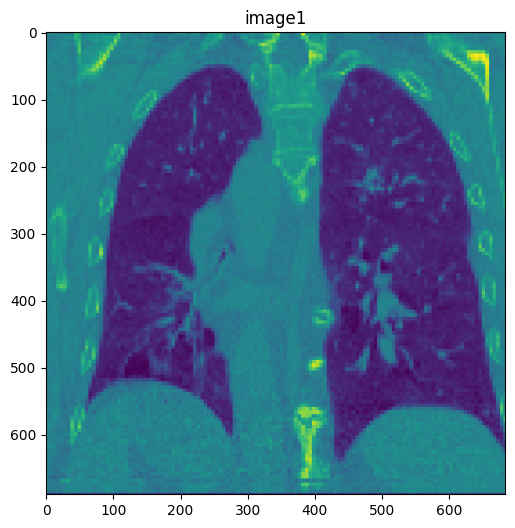

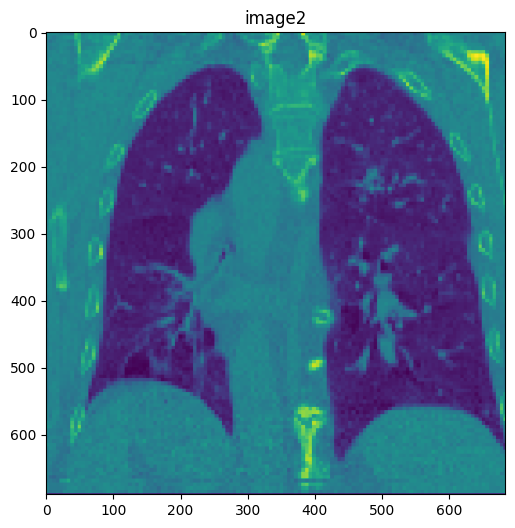

In [218]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.title("image1")
plt.imshow(image1)
plt.figure(figsize=(6, 6))
plt.title("image2")
plt.imshow(image2)
# simage2.shape

* 计算彩色图像的MAE方法

In [228]:
#计算彩色图像的MAE方法
# Reopen the images using the file names directly from the user upload logs
# img1 = Image.open("/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png")
# img2 = Image.open("/workspace/data/Overlap/SSIM&MAE/SMCyan_Mask_Patient5_GT5.png")
# image1 = imread("/workspace/data/Overlap/SSIM&MAE/SMBlue_Mask_Patient5_GT5.png")
# image2 = imread("/workspace/data/Overlap/SSIM&MAE/SMRed_Mask_Patient5_GT5.png")
img1 = Image.open("/workspace/data/Overlap/SSIM&MAE/Shape_Dif/Patient2_GT5.png")
img2 = Image.open("/workspace/data/Overlap/SSIM&MAE/Shape_Dif/Patient6_GT.png")

# Convert images to numpy arrays
img1_array = np.array(img1)
img2_array = np.array(img2)

# Calculate Mean Absolute Error (MAE) for each color channel
mae_red = np.mean(np.abs(img1_array[:, :, 0] - img2_array[:, :, 0]))
mae_green = np.mean(np.abs(img1_array[:, :, 1] - img2_array[:, :, 1]))
mae_blue = np.mean(np.abs(img1_array[:, :, 2] - img2_array[:, :, 2]))

# Calculate overall MAE as the average of the MAE of all channels
mae_overall = (mae_red + mae_green + mae_blue) / 3
mae_overall

90.76971597470151

* 无归一化

In [86]:
from skimage import io
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Load the images
# image1 = imread("/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png")
# image2 = imread("/workspace/data/Overlap/SSIM&MAE/SMPurple_Mask_Patient5_GT5.png")
image1 = imread("/workspace/data/Overlap/SSIM&MAE/Dark.png")
image2 = imread("/workspace/data/Overlap/SSIM&MAE/Light.png")

# image1 = imread("/workspace/data/Overlap/SSIM&MAE/Light_inverse.png")
# image2 = imread("/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Light.png")

# Convert images to grayscale if they are not already
if image1.ndim == 3:
    simage1 = image1[:, :, 0]
if image2.ndim == 3:
    simage2 = image2[:, :, 0]

# Compute SSIM
ssim_index = ssim(simage1, simage2)

# Compute MAE
mae_value = np.mean(np.abs(image1.astype(np.float64) - image2.astype(np.float64)))
print("SSIM:", ssim_index)
print("MAE:", mae_value)

SSIM: 0.26397054607226256
MAE: 110.69326962804445


## Masked

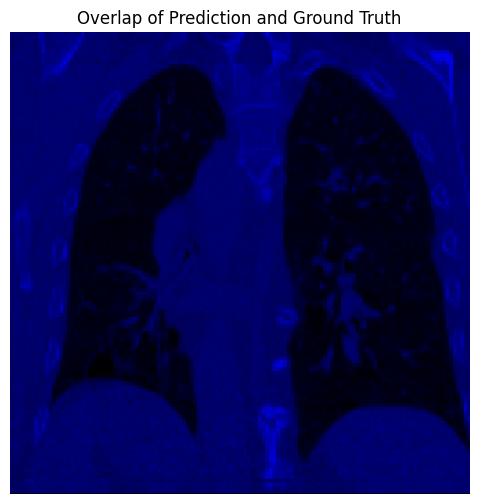

In [85]:
# Green
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the image
img_path = '/workspace/data/Overlap/SSIM&MAE/Patient2_GT5.png'
img = Image.open(img_path).convert('L')  # Convert to grayscale

# Create a mask where the grayscale values are converted to green
img_array = np.array(img)
green_mask = np.zeros((img_array.shape[0], img_array.shape[1], 3), dtype=np.uint8)
green_mask[:, :, 2] = img_array  # Set the green channel to the image values

# Convert back to image
green_mask_img = Image.fromarray(green_mask)

# Save the green mask image
output_path = '/workspace/data/Overlap/SSIM&MAE/SMBlue_Mask_Patient5_GT5.png'
green_mask_img.save(output_path)
output_path

plt.figure(figsize=(6, 6))
plt.imshow(green_mask_img)
plt.title('Overlap of Prediction and Ground Truth')
plt.axis('off')
plt.show()

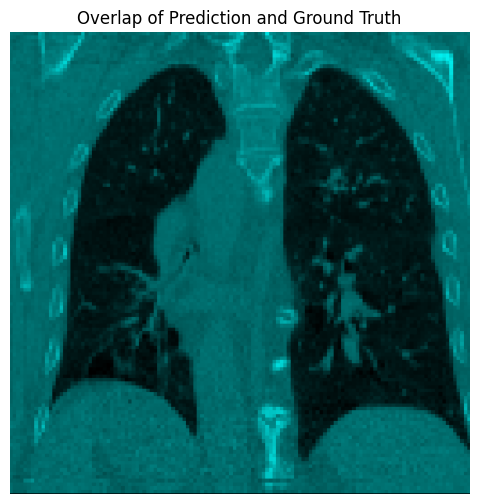

In [197]:
# Purple
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the image
img_path = '/workspace/data/Overlap/SSIM&MAE/Patient2_GT5.png'
img = Image.open(img_path).convert('L')  # Convert to grayscale

# Create a mask where the grayscale values are converted to purple
img_array = np.array(img)
purple_mask = np.zeros((img_array.shape[0], img_array.shape[1], 3), dtype=np.uint8)
purple_mask[:, :, 2] = img_array  # Set the red channel
purple_mask[:, :, 1] = img_array  # Set the blue channel

# Convert back to image
purple_mask_img = Image.fromarray(purple_mask)

# Save the green mask image
output_path = '/workspace/data/Overlap/SSIM&MAE/SMCyan_Mask_Patient5_GT5.png'
purple_mask_img.save(output_path)

plt.figure(figsize=(6, 6))
plt.imshow(purple_mask_img)
plt.title('Overlap of Prediction and Ground Truth')
plt.axis('off')
plt.show()

## BOX PLOT

* SSIM

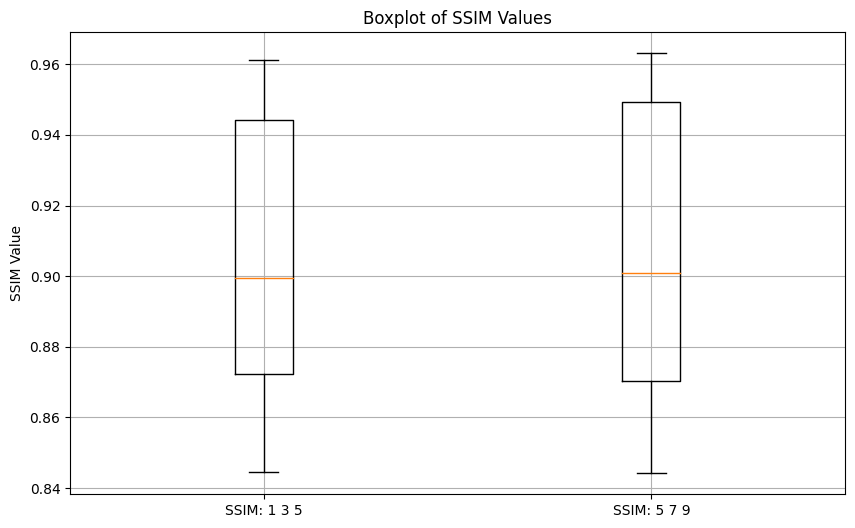

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# First we create a DataFrame from the data provided in the image.
data = {
    'Fold': [1, 2, 3, 4, 5, 6],
    'SSIM: 1 3 5': [0.8718, 0.8445, 0.9252, 0.8735, 0.9613, 0.9505],
    'SSIM: 5 7 9': [0.869, 0.8442, 0.9275, 0.8745, 0.9631, 0.9566],
    'SSIM: 0 2 4': [0.8915, 0.8354, 0.8908, 0.8893, 0.9577, 0.9545],
    'SSIM: 4 6 8': [0.881, 0.8587, 0.9158, 0.8995, 0.9537, 0.9583]
}

df = pd.DataFrame(data)
df.set_index('Fold', inplace=True)

# Now we plot the boxplot using the DataFrame
plt.figure(figsize=(10, 6))
plt.boxplot([df['SSIM: 1 3 5'], df['SSIM: 5 7 9']])
plt.xticks([1, 2], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True)
plt.show()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    'Fold': [1, 2, 3, 4, 5, 6],
    'SSIM: 1 3 5': [0.8915, 0.8354, 0.8908, 0.8893, 0.9577, 0.9545],
    'SSIM: 2 4 6': [0.8718, 0.8445, 0.9252, 0.8735, 0.9613, 0.9505],
    'SSIM: 5 7 9': [0.881, 0.8587, 0.9158, 0.8995, 0.9537, 0.9583],
    'SSIM: 6 8 10': [0.869, 0.8442, 0.9275, 0.8745, 0.9631, 0.9566]
}
df = pd.DataFrame(data)
df.set_index('Fold', inplace=True)

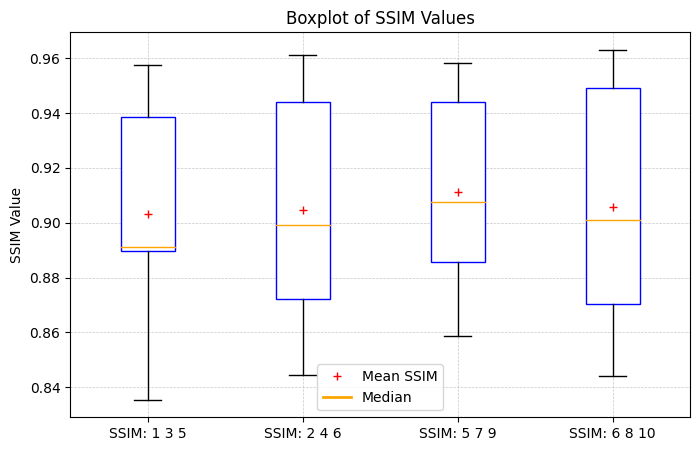

In [2]:
# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(8, 5))

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['SSIM: 1 3 5'], df['SSIM: 2 4 6'], df['SSIM: 5 7 9'], df['SSIM: 6 8 10']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops)

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean SSIM')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0.6,1)

# Show the plot with mean points indicated
plt.show()

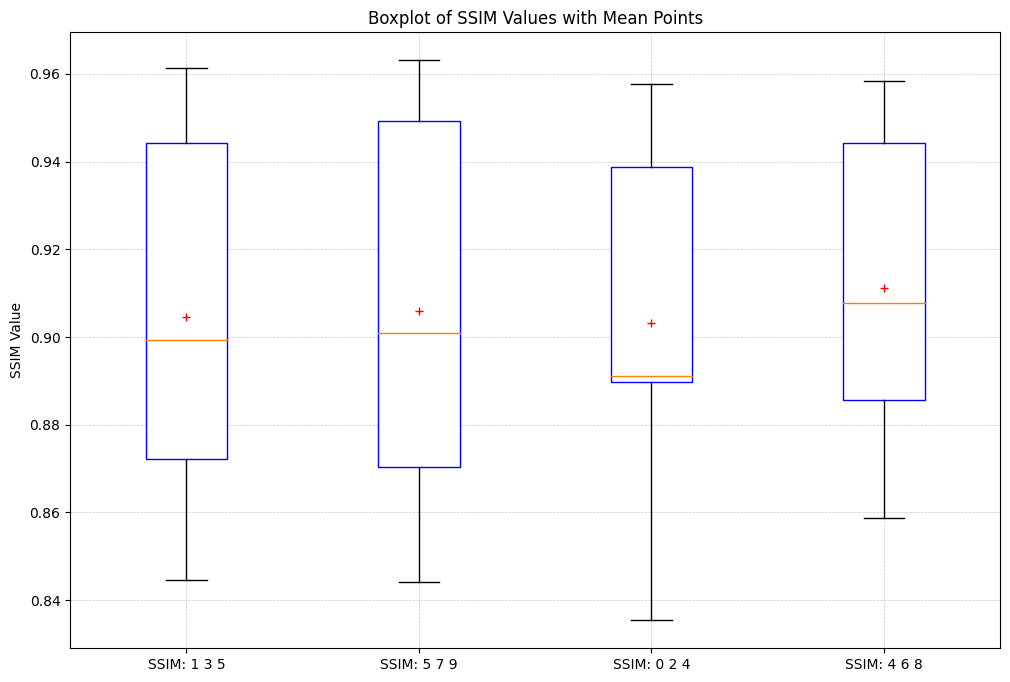

In [55]:
# Correcting the x-ticks to show all four columns of data
plt.figure(figsize=(12, 8))

# Creating the boxplot with mean points for the new data with all four columns
boxplot_elements = plt.boxplot([df[col] for col in df.columns],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               boxprops=boxprops)

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles with all four SSIM values
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.title('Boxplot of SSIM Values with Mean Points')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)